In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
import matplotlib.patches as mpatches

In [25]:
CLN_DATA_PATH='../data/codon_df_clean.csv'

try:
    codon_df_clean = pd.read_csv(CLN_DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: The data file does not exist.")

Data loaded successfully.


In [26]:
from sklearn.preprocessing import LabelEncoder


In [34]:
kingdom_mapped = {'vrl', 'arc', 'bct', 'phg', 'plm', 'pln', 'inv', 'vrt', 'mam', 'rod', 'pri' }
label_encoder = LabelEncoder()

codon_df_clean['Kingdom'] = label_encoder.fit_transform(codon_df_clean['Kingdom'])
codon_df_clean['Kingdom'].value_counts()


Kingdom
1     2919
9     2831
6     2523
10    2077
2     1345
3      572
4      220
8      215
7      180
0      126
5       18
Name: count, dtype: int64

## Bayes model 


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
X = codon_df_clean.drop(columns=['Kingdom', 'SpeciesName'])
y= codon_df_clean['Kingdom']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [48]:
scaler_GNB = StandardScaler()

scaler_GNB.fit(X_train)

X_train_scaled = scaler_GNB.transform(X_train)
X_test_scaled = scaler_GNB.transform(X_test)

In [49]:
bayes = GaussianNB()

bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [50]:
y_train_pred = bayes.predict(X_train_scaled)
y_test_pred = bayes.predict(X_test_scaled)

In [51]:
report_train_GNB = classification_report(y_train, y_train_pred)
print(report_train_GNB)

              precision    recall  f1-score   support

           0       0.21      0.69      0.33        97
           1       0.66      0.38      0.48      2335
           2       0.54      0.36      0.43      1061
           3       0.49      0.71      0.58       461
           4       0.18      0.80      0.30       176
           5       0.03      0.92      0.06        12
           6       0.89      0.39      0.55      2022
           7       0.28      0.26      0.27       141
           8       0.39      0.54      0.45       175
           9       0.51      0.91      0.65      2264
          10       0.94      0.56      0.71      1676

    accuracy                           0.55     10420
   macro avg       0.47      0.59      0.44     10420
weighted avg       0.68      0.55      0.56     10420



In [52]:
report_test_GNB = classification_report(y_test, y_test_pred)
print(report_test_GNB)

              precision    recall  f1-score   support

           0       0.30      0.62      0.40        29
           1       0.65      0.36      0.46       584
           2       0.53      0.40      0.45       284
           3       0.49      0.78      0.61       111
           4       0.20      0.86      0.33        44
           5       0.03      0.50      0.06         6
           6       0.91      0.41      0.56       501
           7       0.32      0.23      0.27        39
           8       0.32      0.45      0.38        40
           9       0.52      0.91      0.66       567
          10       0.93      0.57      0.71       401

    accuracy                           0.56      2606
   macro avg       0.47      0.55      0.44      2606
weighted avg       0.67      0.56      0.56      2606



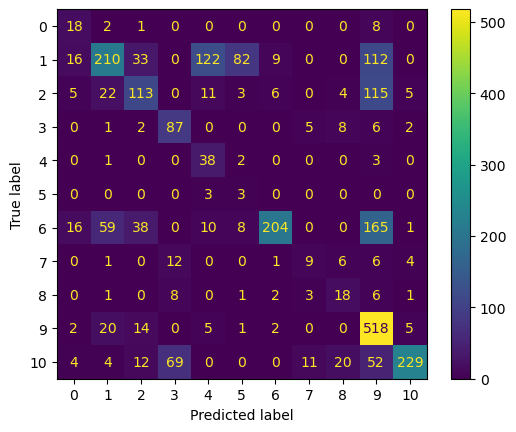

In [59]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()